# Exploratory Data Analysis

## Data Context
The dataset that will be analyzed in this EDA includes [all train services](https://www.rijdendetreinen.nl/en/open-data/train-archive) in the Netherlands since 2019. Each row in these files represent a stop at a station. Each service at least departs from and arrives at a station (i.e. two rows). For each stop, you can find the name of the station, the arrival and departure time, delays and cancellations. The data is already cleaned and tranformed in another notebook called Data_Preparation.ipynb.

Note that many more explorations where done on the dataset prior to this thesis, but only the most valuable information was kept in this notebook.

## Data Loading

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from fuzzywuzzy import process

In [2]:
# Load data from paths
definite_df = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/first_transformation.csv')
trajectories_per_day = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/daily_trajectories.csv')
monthly_trajectories = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/monthly_trajectories.csv')

## Dataframes

In [48]:
# Display the Grouped dataset (transformation 1)
definite_df

,RDT-ID,Trajectory,Date,Day of the Week,Maximum Delay,Arrival Delay of Last Stop (min),Nr. of Planned Stops,Nr. of Cancelled Arrivals,Nr. of Cancelled Departures,Nr. of Delayed Arrivals,Nr. of Delayed Departures,Partly Cancelled,Completely Cancelled,Last Arrival Cancelled,source,target
0,[738804],Rotterdam Centraal - Utrecht Centraal,2019-01-01,Tuesday,1,0.0,5,0,0,2,2,False,False,False,Rotterdam Centraal,Utrecht Centraal
1,[738805],Utrecht Centraal - Rotterdam Centraal,2019-01-01,Tuesday,2,0.0,6,0,0,2,1,False,False,False,Utrecht Centraal,Rotterdam Centraal
2,[738806],Rotterdam Centraal - Utrecht Centraal,2019-01-01,Tuesday,2,0.0,5,0,0,2,2,False,False,False,Rotterdam Centraal,Utrecht Centraal
3,[738807],Utrecht Centraal - Rotterdam Centraal,2019-01-01,Tuesday,2,2.0,5,0,0,2,0,False,False,False,Utrecht Centraal,Rotterdam Centraal
4,[738808],Rotterdam Centraal - Utrecht Centraal,2019-01-01,Tuesday,1,0.0,5,0,0,0,2,False,False,False,Rotterdam Centraal,Utrecht Centraal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7344082,[13487668],Den Haag Centraal - 's-Hertogenbosch,2024-04-30,Tuesday,2,2.0,19,4,4,6,6,True,False,False,Den Haag Centraal,'s-Hertogenbosch
7344083,[13487909],Hoofddorp - Hoorn,2024-04-30,Tuesday,0,0.0,8,8,8,0,0,True,False,False,Hoofddorp,Hoorn
7344084,[13487958],Dordrecht - Venlo,2024-04-30,Tuesday,1,0.0,17,13,13,2,3,True,False,False,Dordrecht,Venlo
7344085,[13488235],Den Haag Ypenburg - Den Haag Centraal,2024-04-30,Tuesday,9,9.0,1,0,0,2,2,False,False,False,Den Haag Ypenburg,Den Haag Centraal


In [47]:
# Display the Daily dataset (transformation 2)
trajectories_per_day

,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,YearMonth
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,2019-01
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,2019-01
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,2019-01
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,2019-01
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,2019-01
...,...,...,...,...,...,...,...,...,...
559663,2024-04-30,Zutphen,'s-Hertogenbosch,1,1,0,0,1,2024-04
559664,2024-04-30,Zutphen,Deventer,1,0,0,0,0,2024-04
559665,2024-04-30,Zutphen,Nijmegen,9,5,1,0,7,2024-04
559666,2024-04-30,Zutphen,Wijchen,24,3,3,0,10,2024-04


In [3]:
# Display the Final/montly dataset (transformation 3)
monthly_trajectories

,YearMonth,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Proportion delayed,Significant Delay
0,2019-01,'s-Hertogenbosch,Arnhem Centraal,57,20,4,0,36,0.350877,True
1,2019-01,'s-Hertogenbosch,Den Haag Centraal,1106,99,20,5,853,0.089918,False
2,2019-01,'s-Hertogenbosch,Deurne,757,247,8,2,503,0.327152,True
3,2019-01,'s-Hertogenbosch,Dordrecht,100,23,3,0,44,0.230000,True
4,2019-01,'s-Hertogenbosch,Eindhoven Centraal,257,81,1,1,138,0.316406,True
...,...,...,...,...,...,...,...,...,...,...
28552,2024-04,Zwolle,Lelystad Centrum,165,10,0,0,46,0.060606,False
28553,2024-04,Zwolle,Nijmegen,28,1,3,0,27,0.035714,False
28554,2024-04,Zwolle,Roosendaal,1047,220,171,12,977,0.212560,True
28555,2024-04,Zwolle,Rotterdam Centraal,24,5,1,0,12,0.208333,False


## Data Exploration

### Grouped Data (transformation 1)

In [13]:
# Let's count the perfect trajectories
perfect_trajectories = definite_df[(definite_df['Nr. of Cancelled Arrivals'] == 0) &
                          (definite_df['Nr. of Cancelled Departures'] == 0) &
                          (definite_df['Nr. of Delayed Arrivals'] == 0) &
                          (definite_df['Nr. of Delayed Departures'] == 0) &
                          (definite_df['Partly Cancelled'] == False)]
num_perfect_trajectories = len(perfect_trajectories)
print("Number of perfect trajectories:", num_perfect_trajectories)


# Let's count the trajectories with canceled departures or arrivals
cancelled_trajectories = definite_df[(definite_df['Nr. of Cancelled Arrivals'] > 0) |
                          (definite_df['Nr. of Cancelled Departures'] > 0)]
num_cancelled_trajectories = len(cancelled_trajectories)
print("Number of trajectories with cancelled departures or arrivals:", num_cancelled_trajectories)


# Let's count the trajectories with delayed arrivals
delayed_arrivals_trajectories = definite_df[(definite_df['Nr. of Delayed Arrivals'] > 0)]
num_delayed_arrivals_trajectories = len(delayed_arrivals_trajectories)
print("Number of trajectories with delayed arrivals:", num_delayed_arrivals_trajectories)


# Let's count the trajectories with delayed departures
delayed_departures_trajectories = definite_df[(definite_df['Nr. of Delayed Departures'] > 0)]
num_delayed_departures_trajectories = len(delayed_departures_trajectories)
print("Number of trajectories with delayed departures:", num_delayed_departures_trajectories)

# Let's count the trajectories that are partly cancelled 
partly_cancelled_trajectories = definite_df[(definite_df['Partly Cancelled'] == True)]
num_partly_cancelled_trajectories = len(partly_cancelled_trajectories)
print("Number of trajectories that were partly cancelled:", num_partly_cancelled_trajectories)

print(len(definite_df))
total = num_perfect_trajectories + num_cancelled_trajectories + num_delayed_arrivals_trajectories + num_delayed_departures_trajectories + num_partly_cancelled_trajectories
print(total)

Number of perfect trajectories: 0


TypeError: '>' not supported between instances of 'str' and 'int'

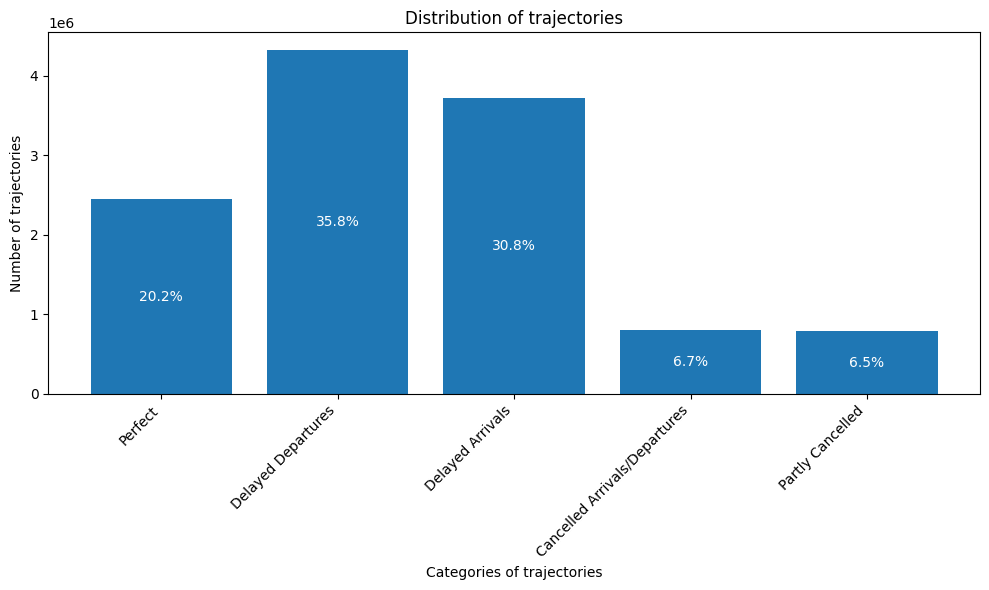

In [64]:
# Define categories and their counts
categories = ['Perfect', 'Delayed Departures', 'Delayed Arrivals','Cancelled Arrivals/Departures', 'Partly Cancelled']
counts = [num_perfect_trajectories, num_delayed_departures_trajectories, num_delayed_arrivals_trajectories, num_cancelled_trajectories, num_partly_cancelled_trajectories]

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts)

# Add labels and title
plt.xlabel('Categories of trajectories')
plt.ylabel('Number of trajectories')
plt.title('Distribution of trajectories')

# Add percentage labels inside the bars
total_trajectories = sum(counts)
for bar, count in zip(bars, counts):
    percentage = count / total_trajectories * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.1f}%', 
             ha='center', va='center', color='white')

# Show plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

Let's create a csv file so we can use this dataframe for our model.

I am curious how many times the last stop of a trajectory is actually canceled. We will need to decide what to do with those.

In [69]:
# Let's count the number of times that the last stop of the trajectory is cancelled 
# Filter the dataframe to get only the rows corresponding to the last stop of each trajectory where 'Stop:Arrival cancelled' is True
cancelled_last_stops = ns_data_definite.groupby('Service:RDT-ID').last()
cancelled_last_stops = cancelled_last_stops[cancelled_last_stops['Stop:Arrival cancelled'] == True]

# Count the number of times that the last stop of the trajectory was cancelled
num_cancelled_last_stop = len(cancelled_last_stops)
print(num_cancelled_last_stop)

615596


In [71]:
# Difference between Nr. of Cancelled Arrivals en Nr. of Cancelled Departures	
# Calculate the number of times the values are different
num_different = (definite_df['Nr. of Cancelled Arrivals'] != definite_df['Nr. of Cancelled Departures']).sum()
print("Number of times 'Nr. of Cancelled Arrivals' is different from 'Nr. of Cancelled Departures':", num_different)

Number of times 'Nr. of Cancelled Arrivals' is different from 'Nr. of Cancelled Departures': 24765


24765

We will need to know the percentage of trajectories with an arrival delay.

In [42]:
# Total number of trajectories
total_trajectories = len(definite_df)

# Number of trajectories with Arrival Delay of Last Stop greater than 0
delayed_countnan = definite_df['Arrival Delay of Last Stop'].isna().sum()
delayed_count0 = len(definite_df[definite_df['Arrival Delay of Last Stop'] == 0])
delayed_count1 = len(definite_df[(definite_df['Arrival Delay of Last Stop'] >= 1) & (definite_df['Arrival Delay of Last Stop'] <= 5)])
delayed_count2 = len(definite_df[(definite_df['Arrival Delay of Last Stop'] >= 6) & (definite_df['Arrival Delay of Last Stop'] <= 10)])
delayed_count10 = len(definite_df[definite_df['Arrival Delay of Last Stop'] > 10])

delayed_count00 = len(definite_df[definite_df['Arrival Delay of Last Stop'] > 0])


# Calculate the percentage
percentage_delayednan = (delayed_countnan / total_trajectories) * 100
percentage_delayed0 = (delayed_count0 / total_trajectories) * 100
percentage_delayed1 = (delayed_count1 / total_trajectories) * 100
percentage_delayed2 = (delayed_count2 / total_trajectories) * 100
percentage_delayed10 = (delayed_count10 / total_trajectories) * 100

percentage_delayed00 = (delayed_count00 / total_trajectories) * 100

print("Percentage of trajectories with last stop canceled", round(percentage_delayednan, 2), "%")
print("Percentage of trajectories with an arrival delay of the last stop exacly 0 minutes:", round(percentage_delayed0, 2), "%")
print("Percentage of trajectories with an arrival delay of the last stop greater than 1 minute and less than 5 minutes:", round(percentage_delayed1, 2), "%")
print("Percentage of trajectories with an arrival delay of the last stop greater than 6 minutes and less than 11 minutes:", round(percentage_delayed2, 2), "%")
print("Percentage of trajectories with an arrival delay of the last stop greater than 10 minutes:", round(percentage_delayed10, 2), "%")

print("Percentage of trajectories with an arrival delay of the last stop greater than 0 minutes:", round(percentage_delayed00, 2), "%")

Percentage of trajectories with last stop canceled 6.53 %
Percentage of trajectories with an arrival delay of the last stop exacly 0 minutes: 72.96 %
Percentage of trajectories with an arrival delay of the last stop greater than 1 minute and less than 5 minutes: 17.02 %
Percentage of trajectories with an arrival delay of the last stop greater than 6 minutes and less than 11 minutes: 1.95 %
Percentage of trajectories with an arrival delay of the last stop greater than 10 minutes: 1.54 %
Percentage of trajectories with an arrival delay of the last stop greater than 0 minutes: 20.51 %


In [76]:
# Number of trajectories with Arrival Delay of Last Stop equal to 0
zero_delay_count = len(definite_df[definite_df['Arrival Delay of Last Stop'] == 0])

# Number of trajectories with Arrival Delay of Last Stop between 1-5 minutes
delay_1_to_5_count = len(definite_df[(definite_df['Arrival Delay of Last Stop'] >= 1) & (definite_df['Arrival Delay of Last Stop'] <= 5)])

# Number of trajectories with Arrival Delay of Last Stop between 6-10 minutes
delay_6_to_10_count = len(definite_df[(definite_df['Arrival Delay of Last Stop'] >= 6) & (definite_df['Arrival Delay of Last Stop'] <= 10)])

# Number of trajectories with Arrival Delay of Last Stop more than 10 minutes
delay_more_than_10_count = len(definite_df[definite_df['Arrival Delay of Last Stop'] > 10])

print("Number of trajectories with Arrival Delay of Last Stop equal to 0:", zero_delay_count)
print("Number of trajectories with Arrival Delay of Last Stop between 1-5 minutes:", delay_1_to_5_count)
print("Number of trajectories with Arrival Delay of Last Stop between 6-10 minutes:", delay_6_to_10_count)
print("Number of trajectories with Arrival Delay of Last Stop more than 10 minutes:", delay_more_than_10_count)

total = zero_delay_count + delay_1_to_5_count + delay_6_to_10_count + delay_more_than_10_count
left = (len((definite_df)) - total)
print("Number or remaining trajectories:", left)

num_nan_delays = definite_df['Arrival Delay of Last Stop'].isna().sum()
print("Number of NaN values in 'Arrival Delay of Last Stop':", num_nan_delays)

Number of trajectories with Arrival Delay of Last Stop equal to 0: 5551906
Number of trajectories with Arrival Delay of Last Stop between 1-5 minutes: 1295064
Number of trajectories with Arrival Delay of Last Stop between 6-10 minutes: 148215
Number of trajectories with Arrival Delay of Last Stop more than 10 minutes: 117325
Number or remaining trajectories: 497166
Number of NaN values in 'Arrival Delay of Last Stop': 497044


In [78]:
nan_delay_rows = definite_df[definite_df['Arrival Delay of Last Stop'].isna()]
nan_delay_rows

,RDT-ID,Trajectory,Date,Day of the Week,Maximum Delay,Arrival Delay of Last Stop,Nr. of Planned Stops,Nr. of Cancelled Arrivals,Nr. of Cancelled Departures,Nr. of Delayed Arrivals,Nr. of Delayed Departures,Partly Cancelled
Service:RDT-ID,,,,,,,,,,,,
739002,[739002],Rotterdam Centraal - Amsterdam Centraal,2019-01-01,Tuesday,0,NaN,1,2,2,0,0,True
739153,[739153],'s-Hertogenbosch - Roosendaal,2019-01-01,Tuesday,0,NaN,3,4,4,0,0,True
739945,[739945],Den Haag Centraal - Eindhoven,2019-01-01,Tuesday,0,NaN,5,6,6,0,0,True
740499,[740499],Eindhoven - Den Haag Centraal,2019-01-01,Tuesday,0,NaN,5,6,6,0,0,True
744021,[744021],Leiden Centraal - Alphen a/d Rijn,2019-01-02,Wednesday,0,NaN,1,2,2,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12700226,[12700226],Amsterdam Centraal - Vlissingen,2023-12-30,Saturday,0,NaN,21,22,22,0,0,True
12700229,[12700229],Dordrecht - Den Haag Centraal,2023-12-30,Saturday,0,NaN,12,13,13,0,0,True
12700230,[12700230],Den Haag Centraal - Dordrecht,2023-12-30,Saturday,0,NaN,12,13,13,0,0,True


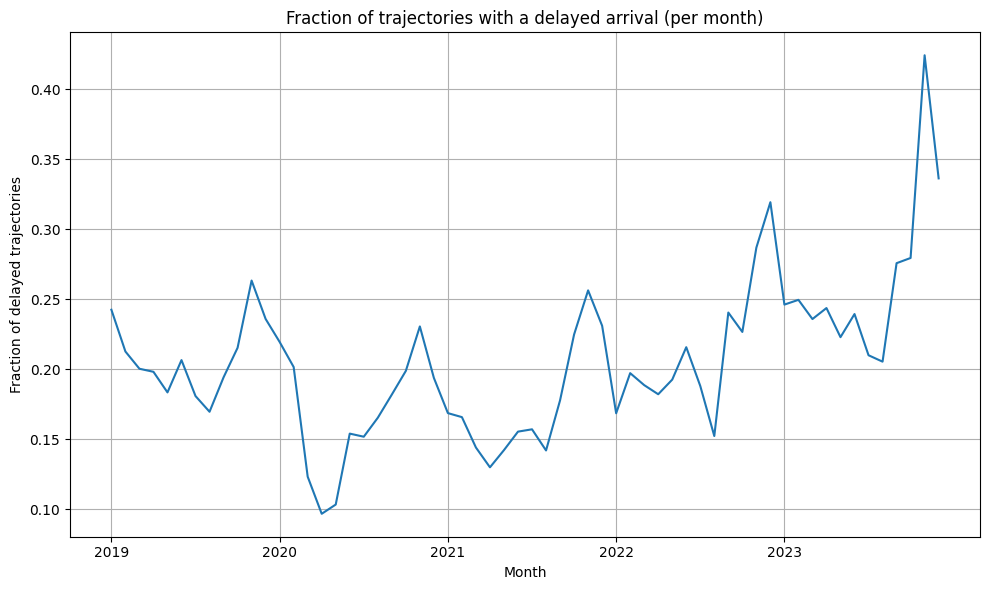

In [17]:
# Convert 'Date' column to datetime format
definite_df['Date'] = pd.to_datetime(definite_df['Date'])

# Extract year and month from the datetime column
definite_df['Year'] = definite_df['Date'].dt.year
definite_df['Month'] = definite_df['Date'].dt.month

# Filter the data for delayed edges (arrival delay of last stop > 0)
delayed_edges = definite_df[definite_df['Arrival Delay of Last Stop'] > 0]

# Group the data by year and month, and count the number of trajectories with delayed edges for each month
delayed_counts = delayed_edges.groupby(['Year', 'Month']).size()

# Calculate the total number of trajectories for each month
total_counts = definite_df.groupby(['Year', 'Month']).size()

# Calculate the percentage of delayed trajectories compared to the total trajectories for each month
percentage_delayed = (delayed_counts / total_counts)

# Reset index to convert MultiIndex to columns
percentage_delayed = percentage_delayed.reset_index()

# Plot the percentages for delayed trajectories
plt.figure(figsize=(10, 6))
plt.plot(range(len(percentage_delayed)), percentage_delayed[0], linestyle='-')
plt.xlabel('Month')
plt.ylabel('Fraction of delayed trajectories')
plt.title('Fraction of trajectories with a delayed arrival (per month)')

# Set x-axis ticks to display years
tick_positions = percentage_delayed.index[::12]    # Show ticks every 12 months (i.e., each year)
tick_labels = percentage_delayed['Year'].unique()  # Use unique years as tick labels
plt.xticks(tick_positions, tick_labels)

plt.grid(True)
plt.tight_layout()
plt.show()


#### Look for timeframe

In this section we will look for the most appropriate timeframe to use.

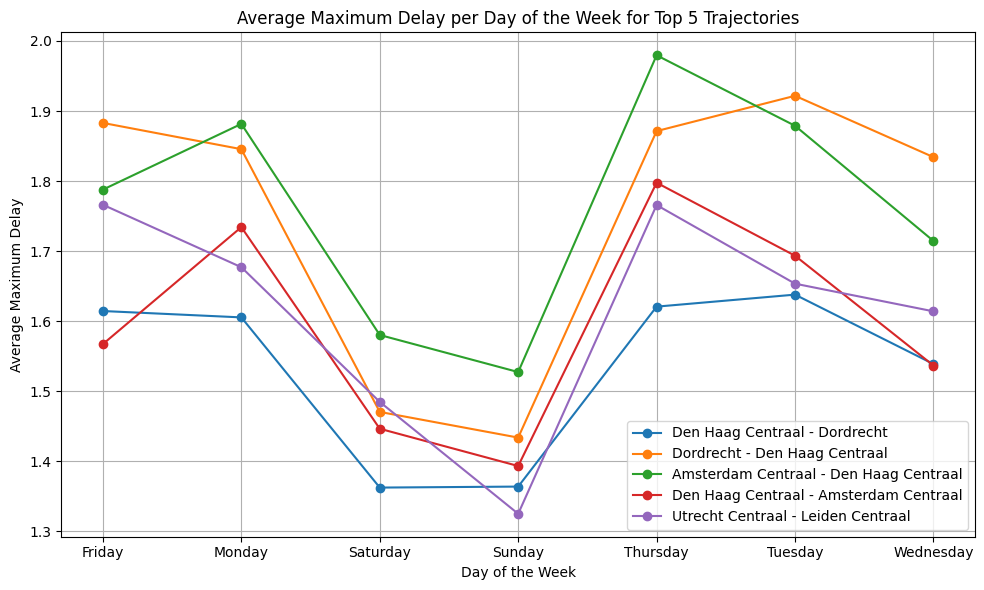

In [14]:
# Find the top 5 most counted trajectories
top_5_trajectories = new_df['Trajectory'].value_counts().head(5).index

# Initialize a dictionary to store the average maximum delay per day of the week for each trajectory
avg_max_delay_per_day = {trajectory: {} for trajectory in top_5_trajectories}

# Calculate the average maximum delay per day of the week for each trajectory
for trajectory in top_5_trajectories:
    # Filter the DataFrame for the current trajectory
    trajectory_data = new_df[new_df['Trajectory'] == trajectory]
    # Group by day of the week and calculate the average maximum delay
    avg_delay = trajectory_data.groupby('Day of the Week')['Maximum Delay'].mean()
    # Store the averages in the dictionary
    avg_max_delay_per_day[trajectory] = avg_delay

# Plot the average maximum delay per day of the week for each trajectory
plt.figure(figsize=(10, 6))
for trajectory, avg_delay in avg_max_delay_per_day.items():
    plt.plot(avg_delay.index, avg_delay.values, marker='o', label=trajectory)

plt.xlabel('Day of the Week')
plt.ylabel('Average Maximum Delay')
plt.title('Average Maximum Delay per Day of the Week for Top 5 Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/3g/j8k6m66124x5lcy646zpdz680000gn/T/ipykernel_41678/4003164858.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajectory_data['Day of the Month'] = pd.to_datetime(trajectory_data['Date of the Trajectory']).dt.day
/var/folders/3g/j8k6m66124x5lcy646zpdz680000gn/T/ipykernel_41678/4003164858.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajectory_data['Day of the Month'] = pd.to_datetime(trajectory_data['Date of the Trajectory']).dt.day
/var/folders/3g/j8k6m66124x5lcy646zpdz680000gn/T

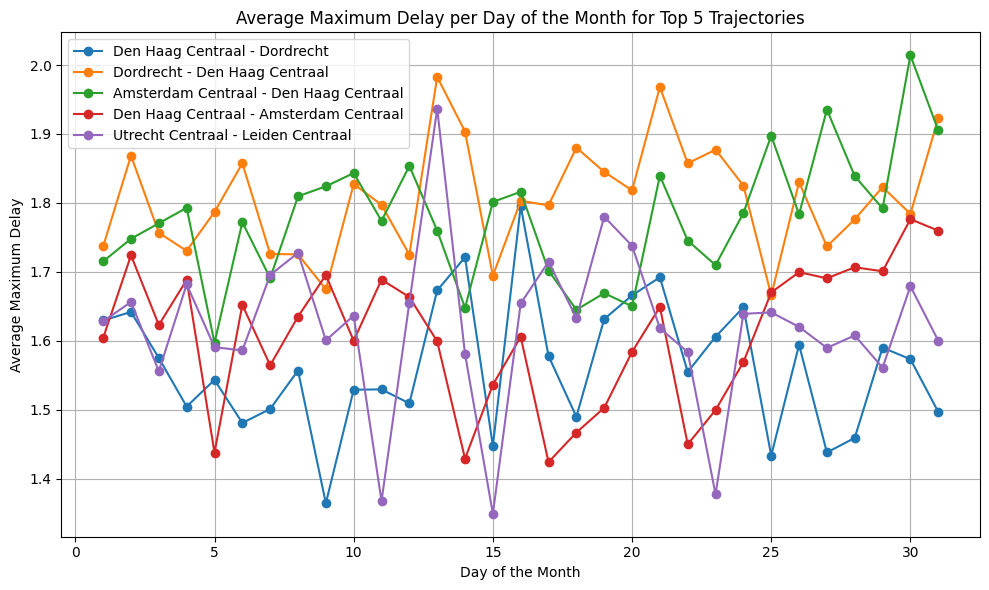

In [15]:
# Find the top 5 most counted trajectories
top_5_trajectories = new_df['Trajectory'].value_counts().head(5).index

# Initialize a dictionary to store the average maximum delay per day of the month for each trajectory
avg_max_delay_per_day_of_month = {trajectory: {} for trajectory in top_5_trajectories}

# Calculate the average maximum delay per day of the month for each trajectory
for trajectory in top_5_trajectories:
    # Filter the DataFrame for the current trajectory
    trajectory_data = new_df[new_df['Trajectory'] == trajectory]
    # Extract the day of the month from the date
    trajectory_data['Day of the Month'] = pd.to_datetime(trajectory_data['Date of the Trajectory']).dt.day
    # Group by day of the month and calculate the average maximum delay
    avg_delay = trajectory_data.groupby('Day of the Month')['Maximum Delay'].mean()
    # Store the averages in the dictionary
    avg_max_delay_per_day_of_month[trajectory] = avg_delay

# Plot the average maximum delay per day of the month for each trajectory
plt.figure(figsize=(10, 6))
for trajectory, avg_delay in avg_max_delay_per_day_of_month.items():
    plt.plot(avg_delay.index, avg_delay.values, marker='o', label=trajectory)

plt.xlabel('Day of the Month')
plt.ylabel('Average Maximum Delay')
plt.title('Average Maximum Delay per Day of the Month for Top 5 Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/3g/j8k6m66124x5lcy646zpdz680000gn/T/ipykernel_41678/3313364169.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajectory_data['Month'] = pd.to_datetime(trajectory_data['Date of the Trajectory']).dt.month
/var/folders/3g/j8k6m66124x5lcy646zpdz680000gn/T/ipykernel_41678/3313364169.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajectory_data['Month'] = pd.to_datetime(trajectory_data['Date of the Trajectory']).dt.month
/var/folders/3g/j8k6m66124x5lcy646zpdz680000gn/T/ipykernel_41678/3

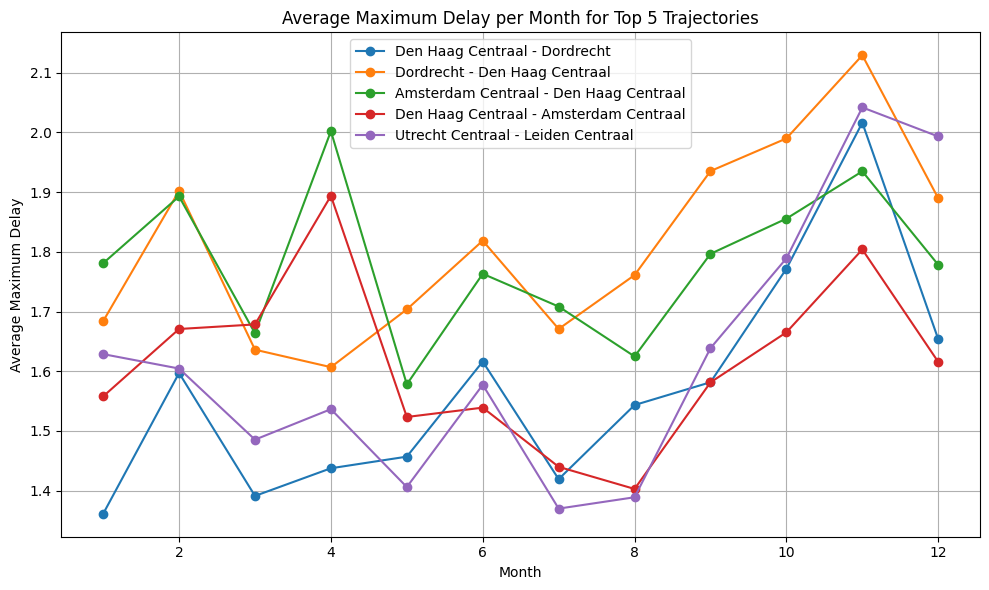

In [16]:
# Find the top 5 most counted trajectories
top_5_trajectories = new_df['Trajectory'].value_counts().head(5).index

# Initialize a dictionary to store the average maximum delay per month for each trajectory
avg_max_delay_per_month = {trajectory: {} for trajectory in top_5_trajectories}

# Calculate the average maximum delay per month for each trajectory
for trajectory in top_5_trajectories:
    # Filter the DataFrame for the current trajectory
    trajectory_data = new_df[new_df['Trajectory'] == trajectory]
    # Extract the month from the date
    trajectory_data['Month'] = pd.to_datetime(trajectory_data['Date of the Trajectory']).dt.month
    # Group by month and calculate the average maximum delay
    avg_delay = trajectory_data.groupby('Month')['Maximum Delay'].mean()
    # Store the averages in the dictionary
    avg_max_delay_per_month[trajectory] = avg_delay

# Plot the average maximum delay per month for each trajectory
plt.figure(figsize=(10, 6))
for trajectory, avg_delay in avg_max_delay_per_month.items():
    plt.plot(avg_delay.index, avg_delay.values, marker='o', label=trajectory)

plt.xlabel('Month')
plt.ylabel('Average Maximum Delay')
plt.title('Average Maximum Delay per Month for Top 5 Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

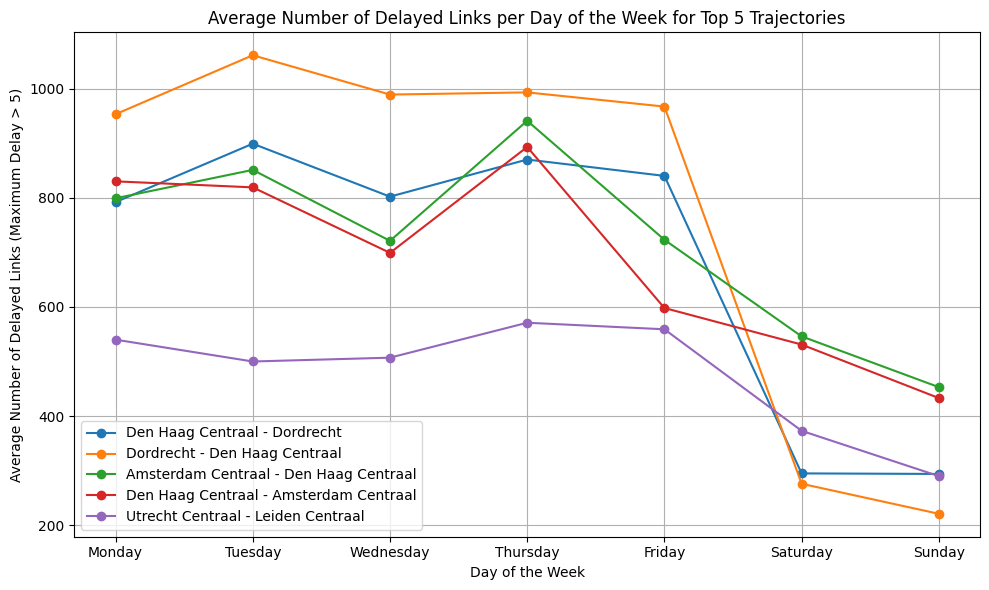

In [29]:
from pandas.api.types import CategoricalDtype

# Find the top 5 most counted trajectories
top_5_trajectories = new_df['Trajectory'].value_counts().head(5).index

# Initialize a dictionary to store the average number of delayed links per day of the week for each trajectory
avg_delayed_links_per_day = {trajectory: {} for trajectory in top_5_trajectories}

# Define the order of the days of the week
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert the 'Day of the Week' column to a categorical data type with the specified order
new_df['Day of the Week'] = new_df['Day of the Week'].astype(CategoricalDtype(categories=days_of_week_order, ordered=True))

# Calculate the average number of delayed links per day of the week for each trajectory
for trajectory in top_5_trajectories:
    # Filter the DataFrame for the current trajectory and where Maximum Delay is greater than 0
    trajectory_data = new_df[(new_df['Trajectory'] == trajectory) & (new_df['Maximum Delay'] > 5)]
    # Group by day of the week and count the number of rows in each group
    avg_delayed_links = trajectory_data.groupby('Day of the Week').size()
    # Store the counts in the dictionary
    avg_delayed_links_per_day[trajectory] = avg_delayed_links
    
# Plot the average number of delayed links per day of the week for each trajectory
plt.figure(figsize=(10, 6))
for trajectory, avg_delayed_links in avg_delayed_links_per_day.items():
    plt.plot(avg_delayed_links.index, avg_delayed_links.values, marker='o', label=trajectory)

plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Delayed Links (maximum delay > 5 minutes)')
plt.title('Average Number of Delayed Links per Day of the Week for Top 5 Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Daily Data (tranformation 2)

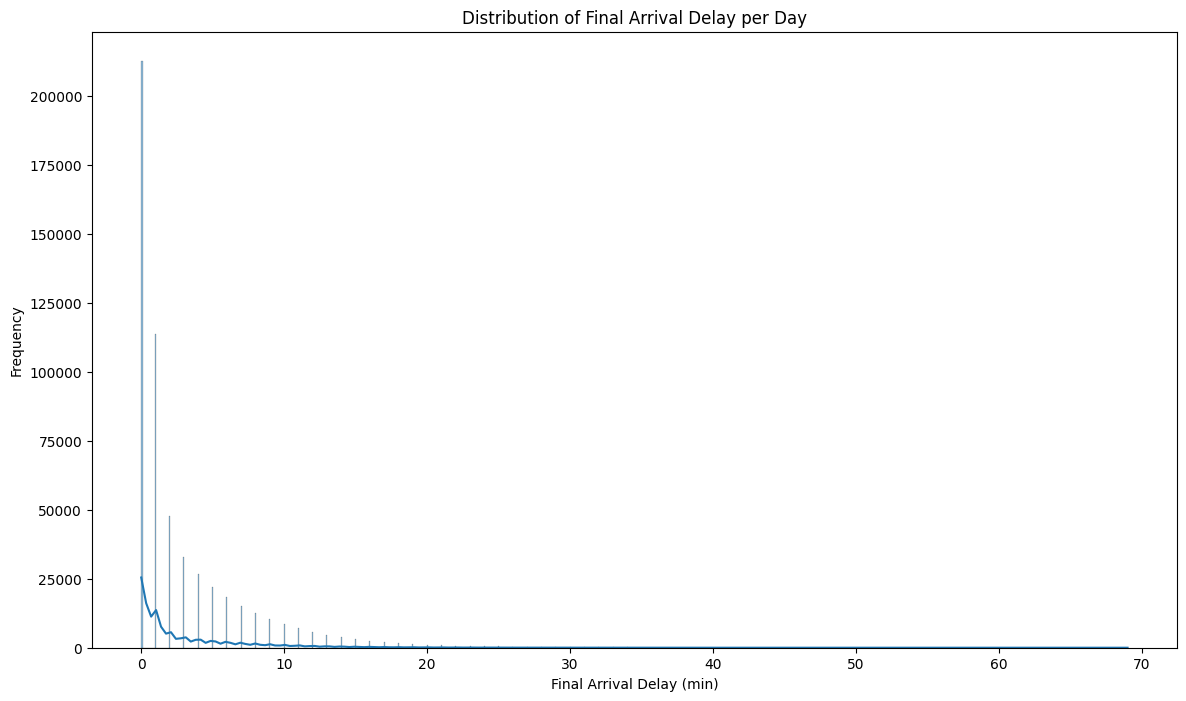

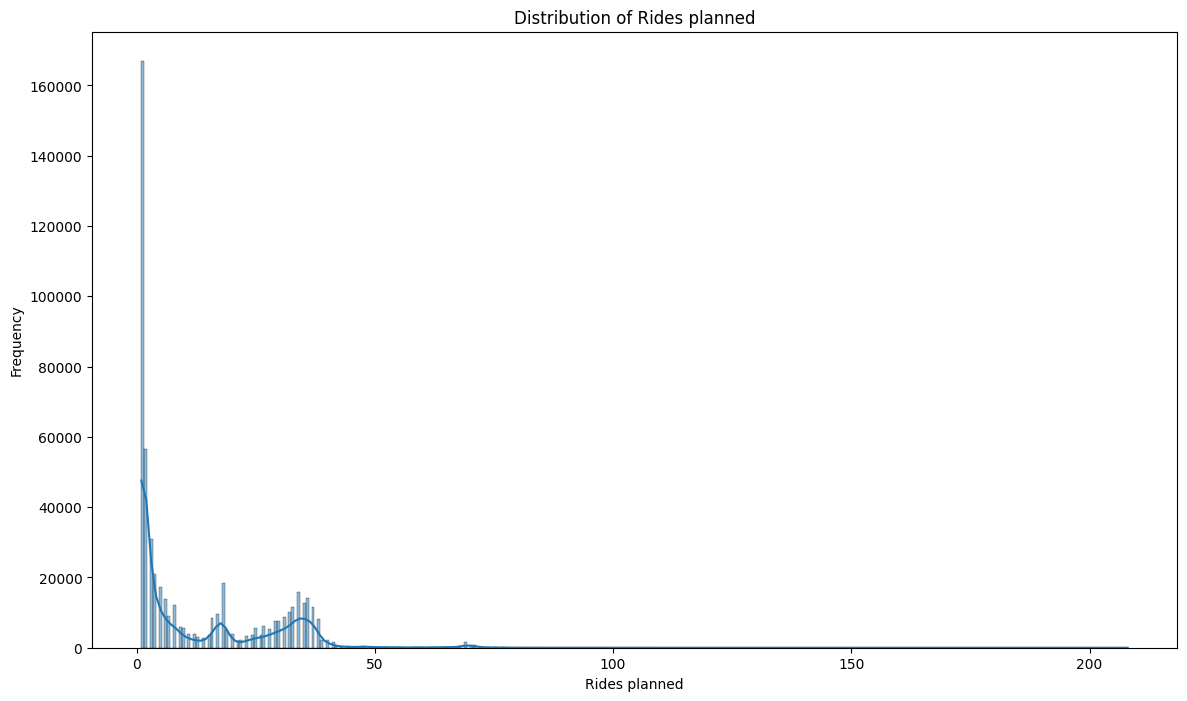

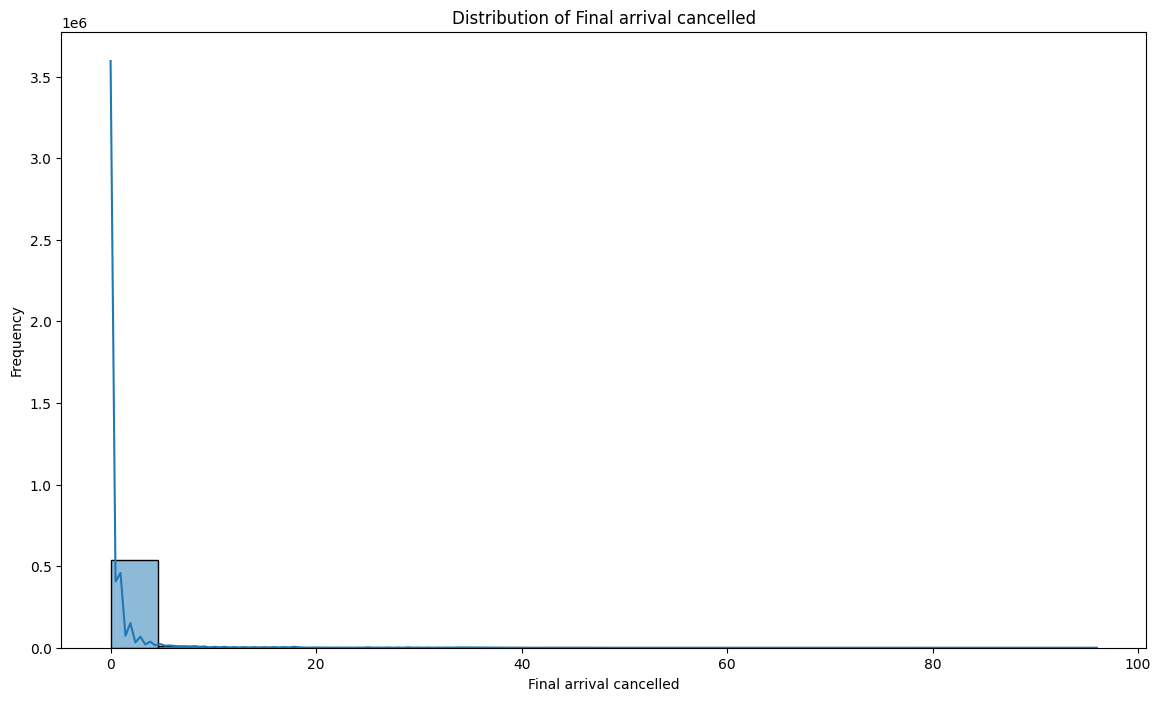

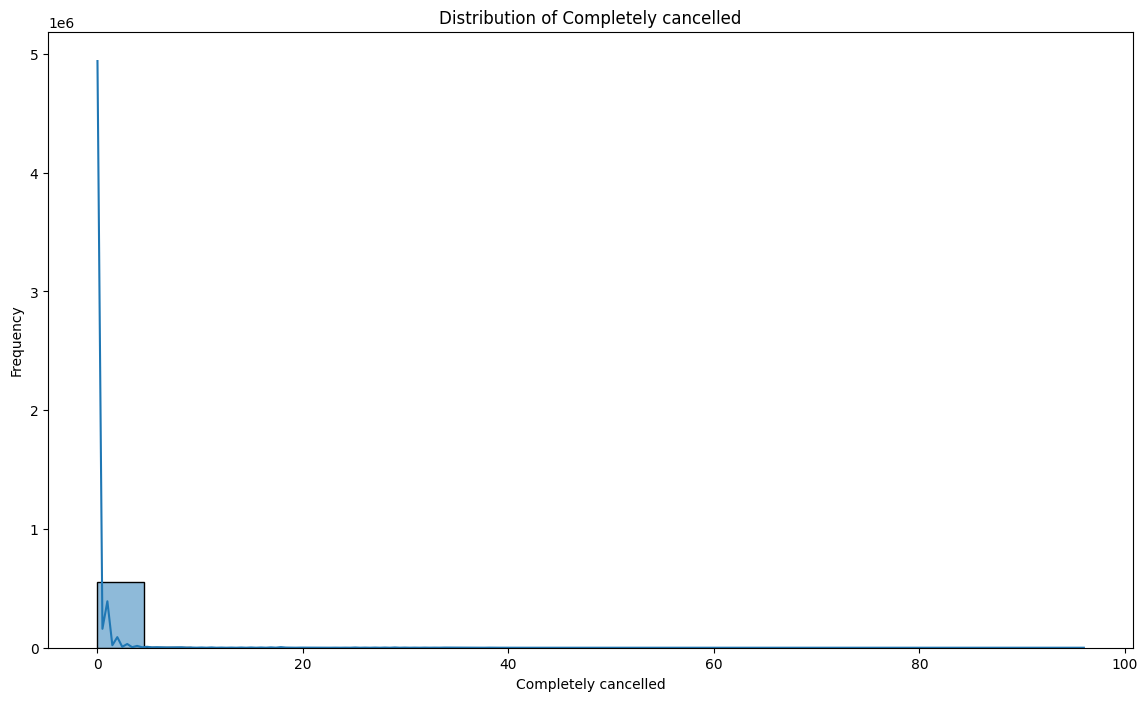

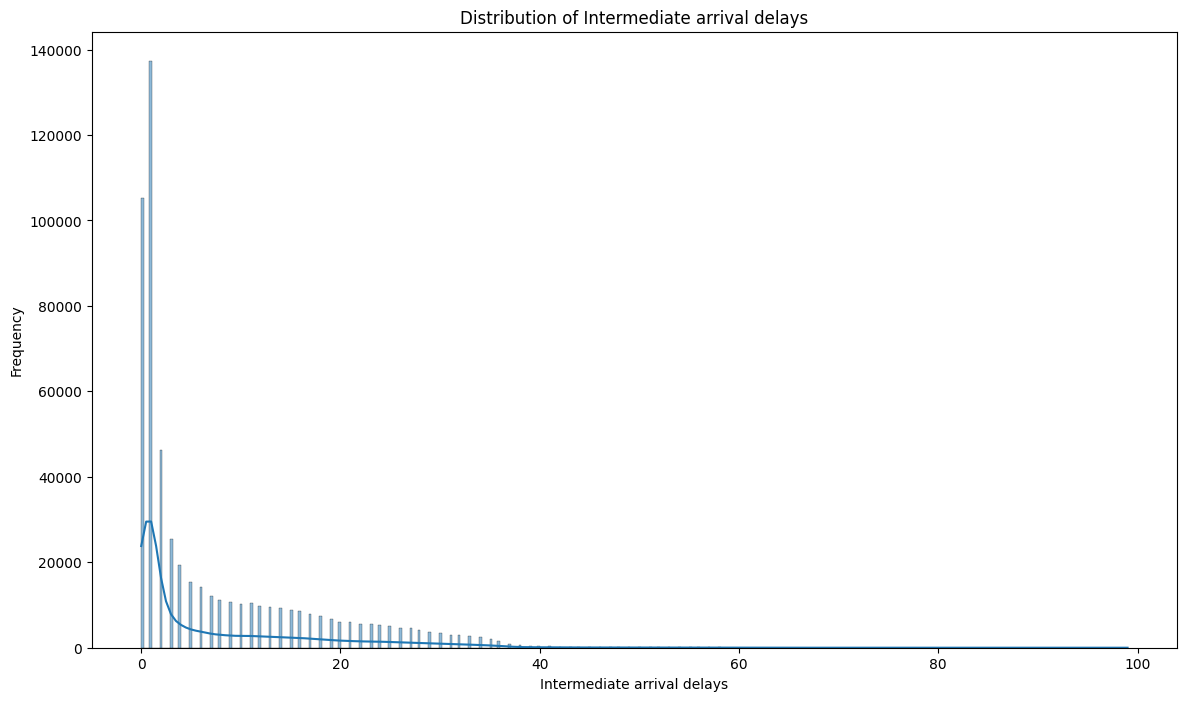

In [17]:
# Plot distributions for Trajectories_per_day
plt.figure(figsize=(14, 8))
sns.histplot(trajectories_per_day['Final arrival delay'], kde=True)
plt.title('Distribution of Final Arrival Delay per Day')
plt.xlabel('Final Arrival Delay (min)')
plt.ylabel('Frequency')
plt.show()

# Repeat for other relevant features
features = ['Rides planned', 'Final arrival cancelled', 'Completely cancelled', 'Intermediate arrival delays']

for feature in features:
    plt.figure(figsize=(14, 8))
    sns.histplot(trajectories_per_day[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


### Montly Data (transformation 3 - Final Dataset)

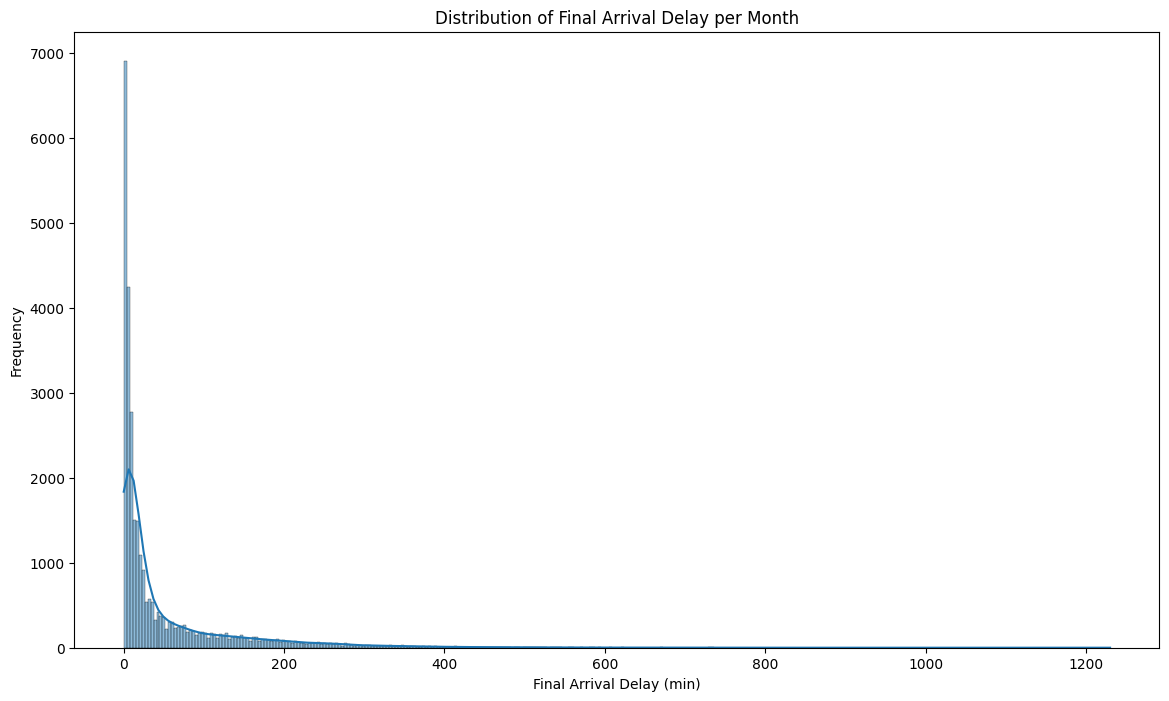

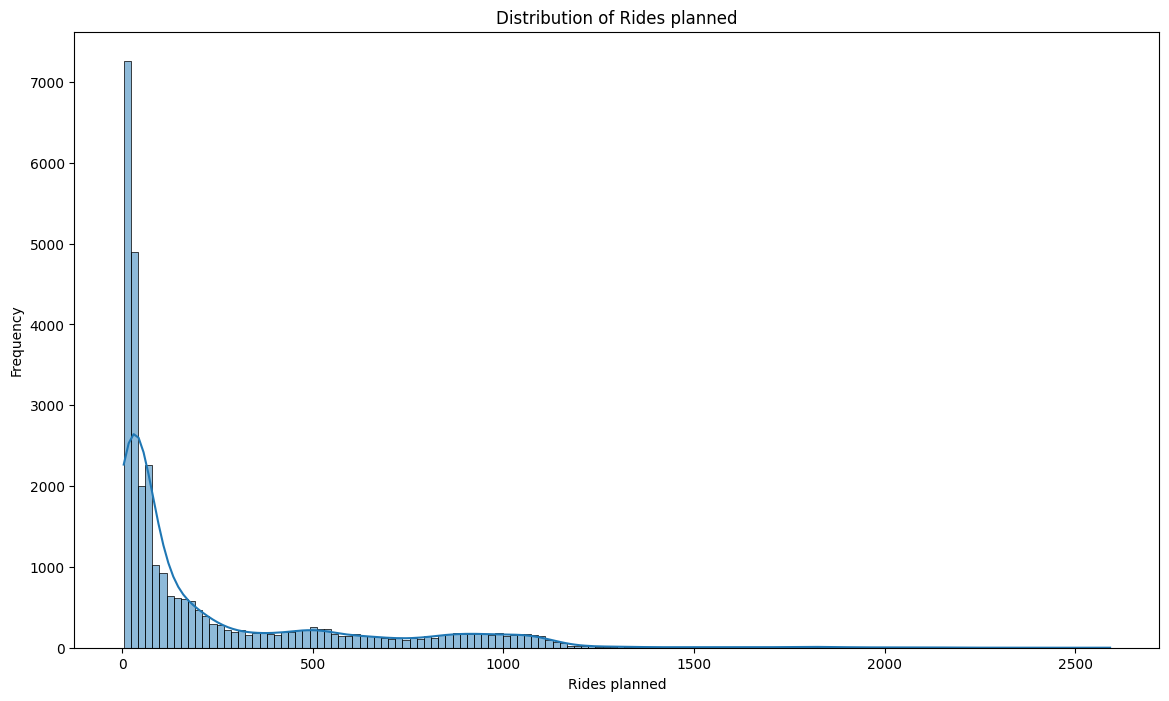

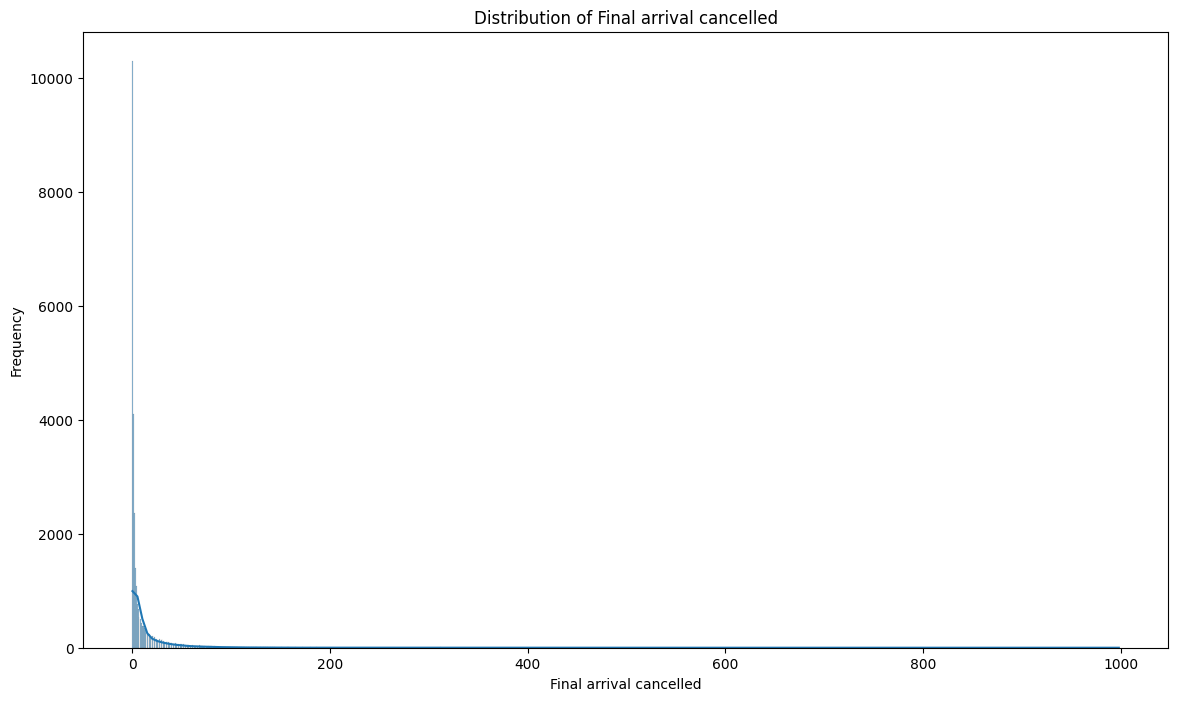

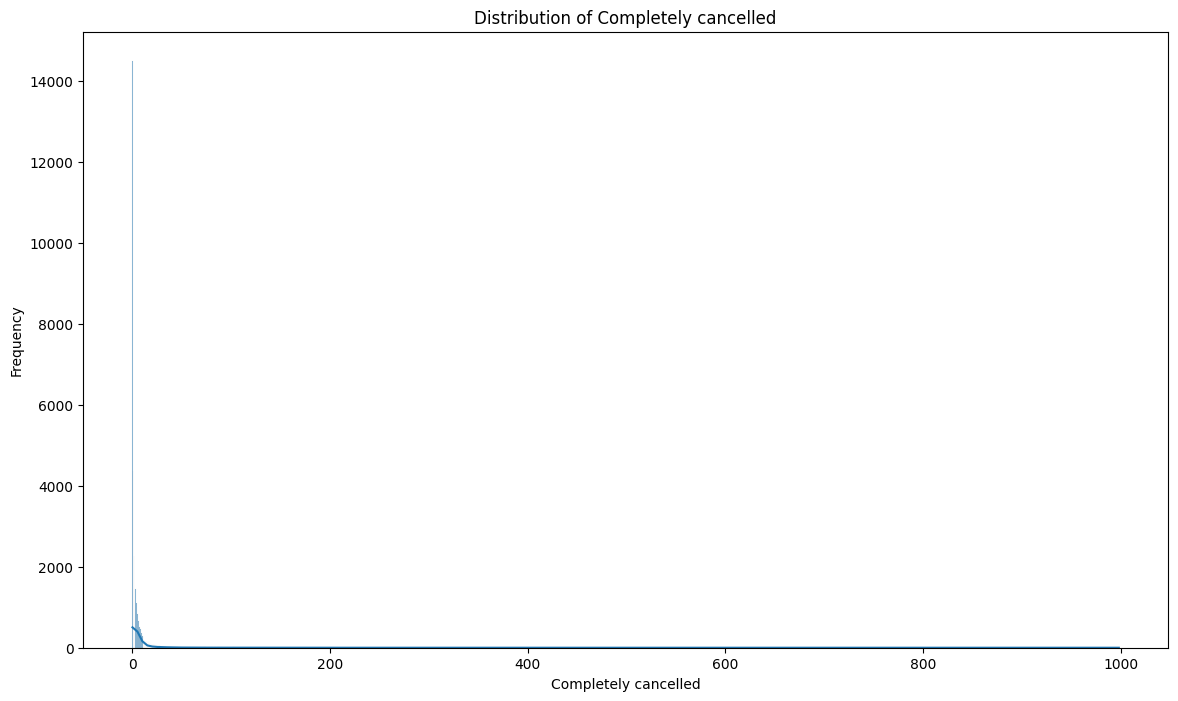

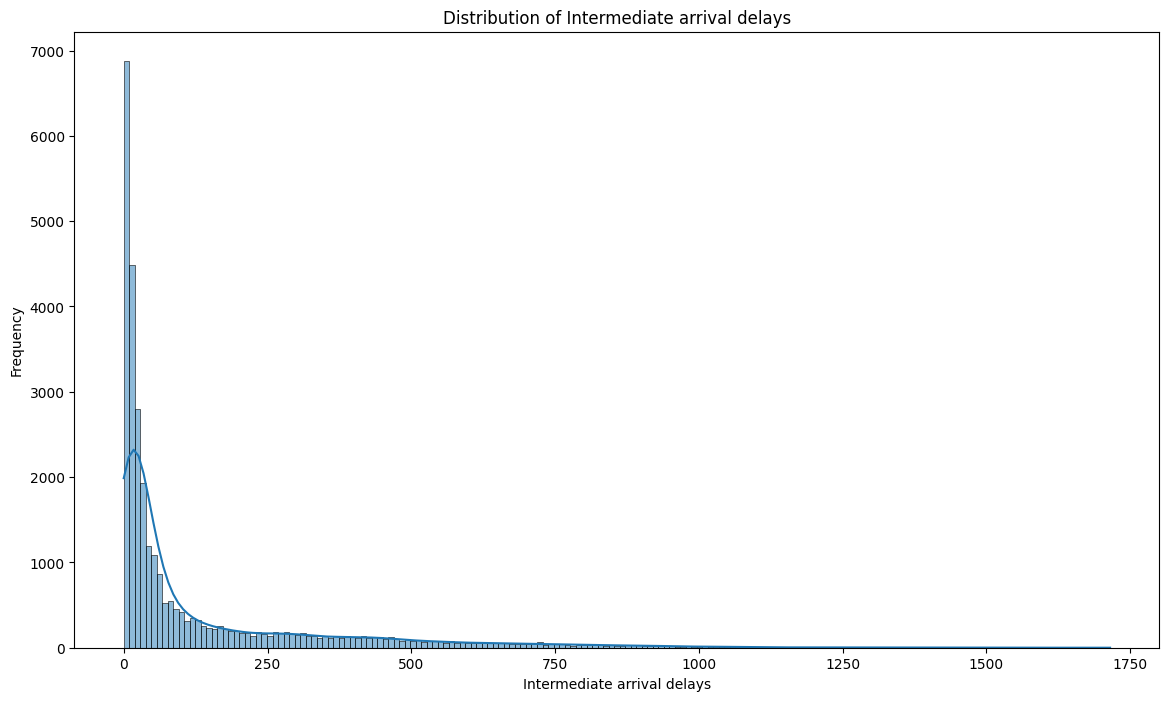

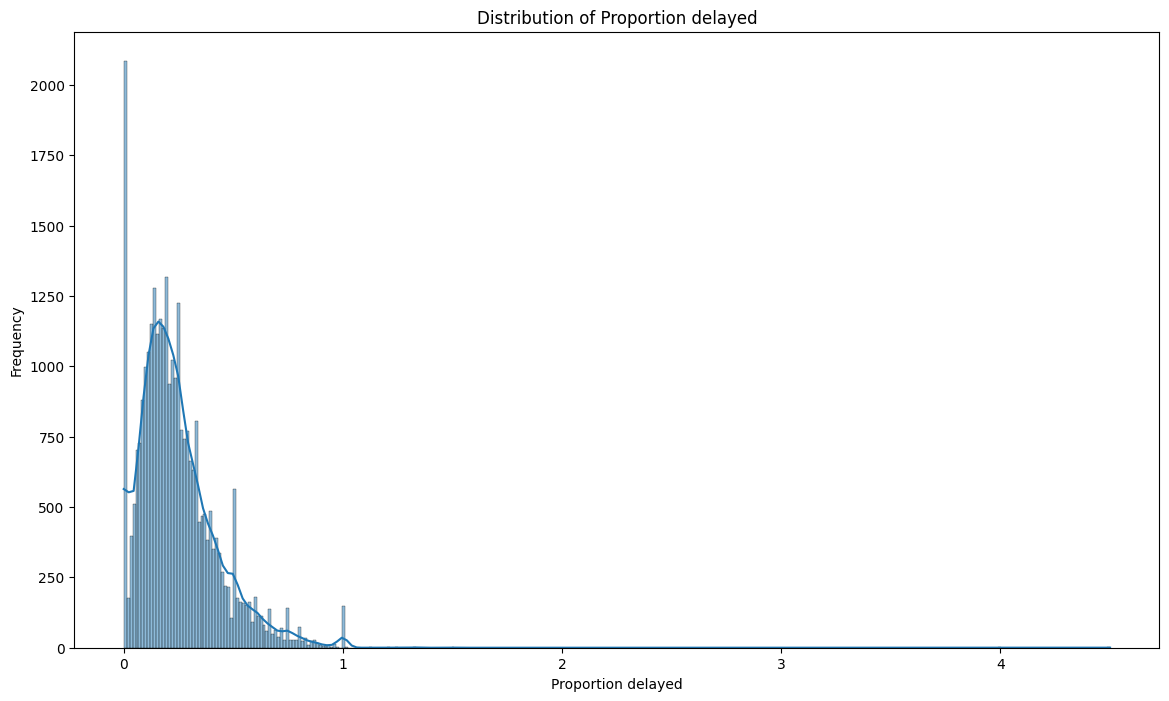

In [18]:
# Plot distributions for Monthly_trajectories
plt.figure(figsize=(14, 8))
sns.histplot(monthly_trajectories['Final arrival delay'], kde=True)
plt.title('Distribution of Final Arrival Delay per Month')
plt.xlabel('Final Arrival Delay (min)')
plt.ylabel('Frequency')
plt.show()

# Repeat for other relevant features
features = ['Rides planned', 'Final arrival cancelled', 'Completely cancelled', 'Intermediate arrival delays', 'Proportion delayed']

for feature in features:
    plt.figure(figsize=(14, 8))
    sns.histplot(monthly_trajectories[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

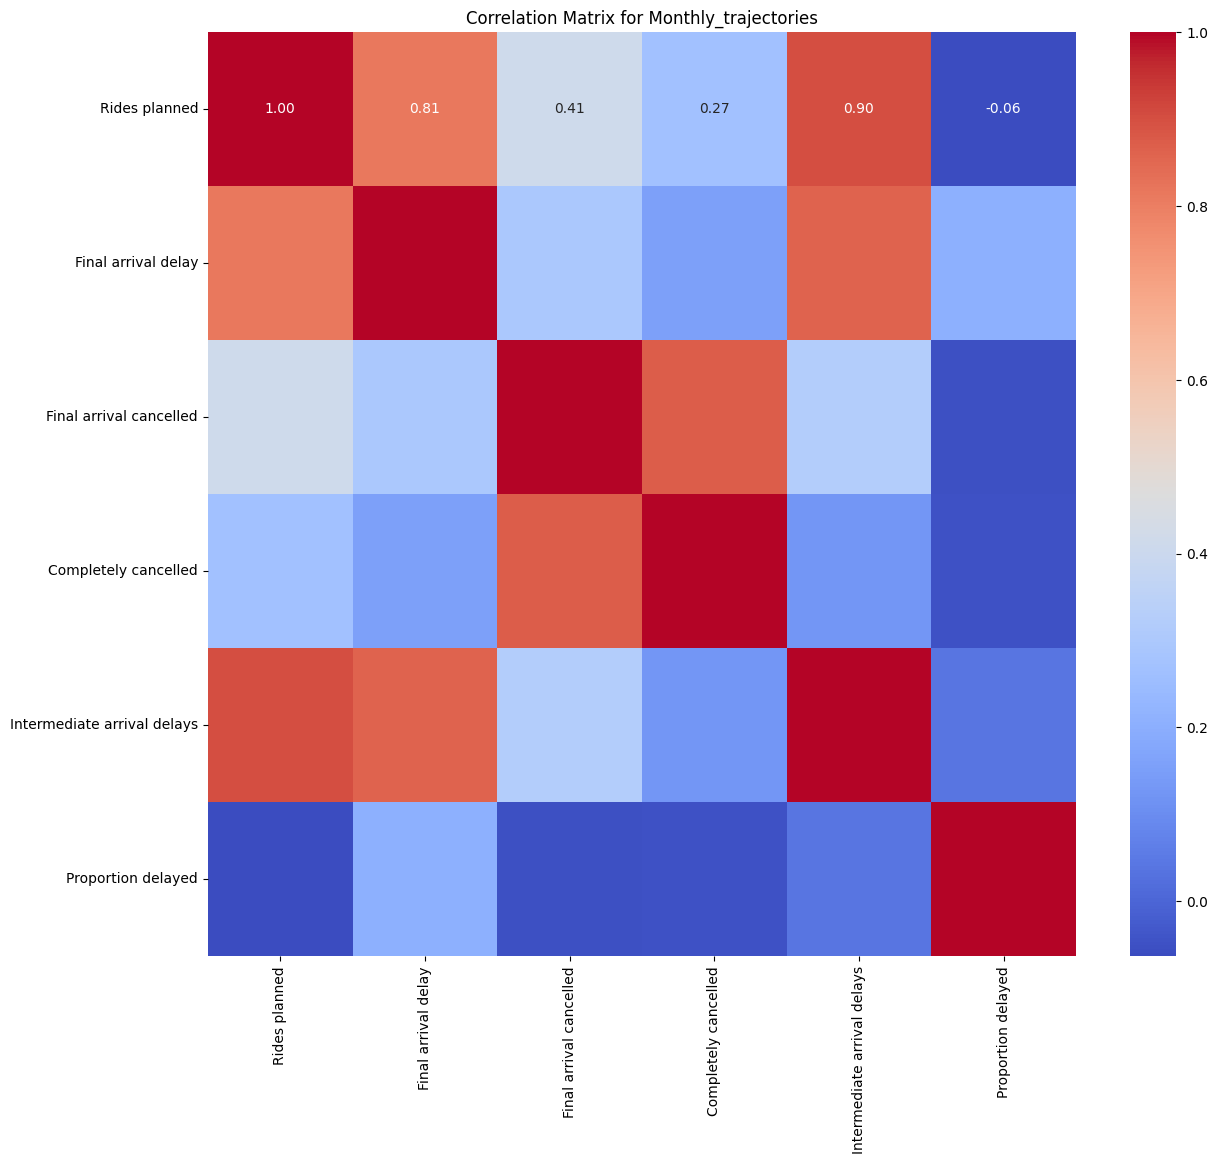

In [26]:
# Filter numeric columns
numeric_cols = monthly_trajectories.select_dtypes(include=['number']).columns
numeric_df = monthly_trajectories[numeric_cols]

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Monthly_trajectories')
plt.show()

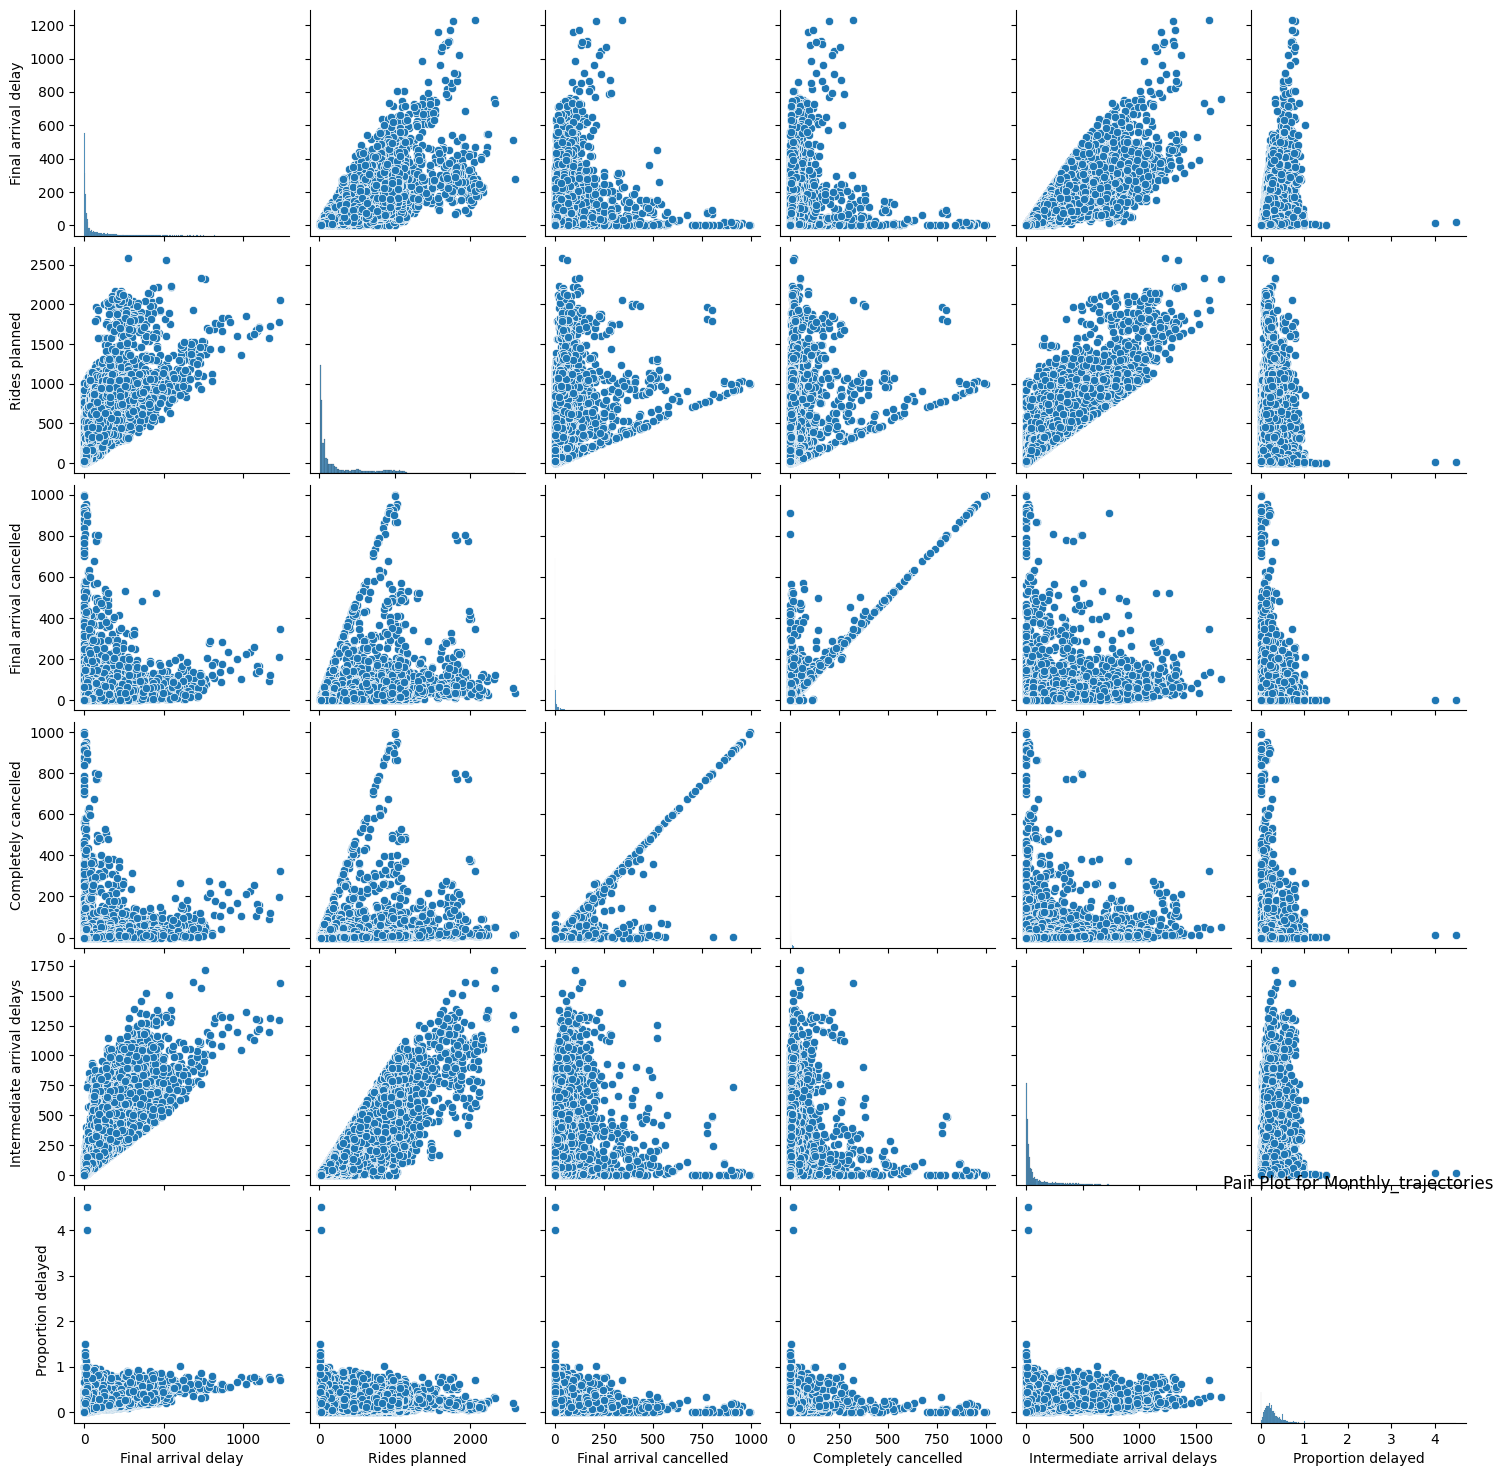

In [27]:
# Pair plot for Monthly_trajectories
sns.pairplot(monthly_trajectories[['Final arrival delay', 'Rides planned', 'Final arrival cancelled', 
                                   'Completely cancelled', 'Intermediate arrival delays', 'Proportion delayed']])
plt.title('Pair Plot for Monthly_trajectories')
plt.show()

## External Datasets

#### Create Distance Map

First we will create a **distance overview** from every station to every station based on the matrix from: https://www.rijdendetreinen.nl/en/open-data/station-distances.

In [34]:
# STEP 1: Get distances for codes
matrix_df = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/distances_ns_international.csv', index_col=0)

origin_codes = []
destination_codes = []
distances = []

for origin_code in matrix_df.index:
    for destination_code in matrix_df.columns:
        distance = matrix_df.loc[origin_code, destination_code]
        if distance != 'XXX' and distance != '?': 
            origin_codes.append(origin_code)
            destination_codes.append(destination_code)
            distances.append(distance)

new_df = pd.DataFrame({
    'origin_code': origin_codes,
    'destination_code': destination_codes,
    'distance': distances
})

# STEP 2: Let's change the codes to names
path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/stations_data'
files = os.listdir(path)
dfs=[]
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)
station_df = pd.concat(dfs, ignore_index=True)

code_to_name = dict(zip(station_df['code'], station_df['name_long']))

newer_df = new_df.copy()  # Create a copy of new_df to avoid modifying the original DataFrame
newer_df['origin_name'] = new_df['origin_code'].map(code_to_name)
newer_df['destination_name'] = new_df['destination_code'].map(code_to_name)

newer_df.drop(['origin_code', 'destination_code'], axis=1, inplace=True)
newer_df = newer_df[['origin_name', 'destination_name', 'distance']]

# STEP 3: Additional Modifications
distances = newer_df.copy() 
distances['origin_name'] = distances['origin_name'].replace({'Amersfoort': 'Amersfoort Centraal', 'Eindhoven': 'Eindhoven Centraal'})
distances['destination_name'] = distances['destination_name'].replace({'Amersfoort': 'Amersfoort Centraal', 'Eindhoven': 'Eindhoven Centraal'})

In [40]:
distances.to_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/station_distances.csv')

#### Create population dataset

Furthermore, we will create a **population overview** of every station based on a list from: https://www.cbs.nl/nl-nl/visualisaties/dashboard-bevolking/regionaal/inwoners.

In [43]:
# STEP 1: Get unique values from the 'source' and 'target' columns separately
unique_origin = trajectories_per_day['source'].unique()
unique_destination = trajectories_per_day['target'].unique()
unique_stations = np.unique(np.concatenate([unique_origin, unique_destination]))
unique_stations_normalized = [station.lower().replace("'", "") for station in unique_stations]

population_regions = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/population-nl-2023.csv', index_col=0, delimiter=';')
population_regions['Normalized Region'] = population_regions.index.str.lower().str.replace("'", "")
population_regions.index = population_regions.index.str.lower().str.replace("'", "")

population = []

for station in unique_stations_normalized:
    match = process.extractOne(station, population_regions.index)
    
    if match[1] > 70:
        population_value = population_regions.loc[match[0], 'Inwonersaantal']
        population.append(population_value)
        #print(f"Station: {station}, Population: {population_value}")
    else:
        population.append(None)
        #print(f"No match found for station: {station}")

population_stations_nl = pd.DataFrame({'Station': unique_stations, 'Population': population})

In [44]:
population_stations_nl.to_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/data/station_populations.csv')